## IMPORTING LIBRARY


In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
X = []
Y = []

for i in tqdm(glob('train/Open_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(1)
    
for i in tqdm(glob('train/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(0)    

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:23<00:00, 85.30it/s]


In [3]:
X = np.array(X)
X = X/255.0
Y = np.array(Y)

In [4]:
X.shape

(4000, 64, 64)

In [5]:
X = np.expand_dims(X,-1)

In [6]:
X.shape

(4000, 64, 64, 1)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten

In [9]:
model = tf.keras.models.Sequential([
      Input(shape=(64, 64, 1)),

      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu'),
      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Flatten(),
      Dense(units  = 256, activation = 'relu', use_bias=False),
      BatchNormalization(),

      Dense(units = 128, use_bias=False, activation = 'relu'),

      Dense(units = 84, use_bias=False, activation = 'relu'),
      BatchNormalization(),
      Dropout(0.3),

      Dense(units = 1, activation = 'sigmoid')
  ])

In [10]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [11]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestModel.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)
model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback)

Epoch 1/30


67/67 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.9552
Epoch 1: val_loss improved from inf to 0.99811, saving model to bestModel.h5
67/67 [==============================] - 17s 220ms/step - loss: 0.1163 - accuracy: 0.9552 - val_loss: 0.9981 - val_accuracy: 0.5187
Epoch 2/30


C:\Users\sinha\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9907
Epoch 2: val_loss did not improve from 0.99811
67/67 [==============================] - 15s 219ms/step - loss: 0.0303 - accuracy: 0.9907 - val_loss: 2.0847 - val_accuracy: 0.5187
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9944
Epoch 3: val_loss did not improve from 0.99811
67/67 [==============================] - 15s 221ms/step - loss: 0.0227 - accuracy: 0.9944 - val_loss: 2.0830 - val_accuracy: 0.5187
Epoch 4/30
67/67 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9972
Epoch 4: val_loss did not improve from 0.99811
67/67 [==============================] - 15s 217ms/step - loss: 0.0130 - accuracy: 0.9972 - val_loss: 2.4336 - val_accuracy: 0.5317
Epoch 5/30
67/67 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9879
Epoch 5: val_loss improved from 0.99811 to 0.36276, saving model to bestModel.h5
67/67 [==========

In [12]:
model.evaluate(x_test, y_test)

42/42 [==============================] - 2s 47ms/step - loss: 0.0347 - accuracy: 0.9902


[0.034660305827856064, 0.9901515245437622]

In [17]:
from keras.models import load_model
best_model = load_model('bestModel.h5')
best_model.evaluate(x_test, y_test)

42/42 [==============================] - 2s 48ms/step - loss: 0.0067 - accuracy: 0.9977


[0.006691598799079657, 0.9977272748947144]

1/1 [==============================] - 0s 190ms/step


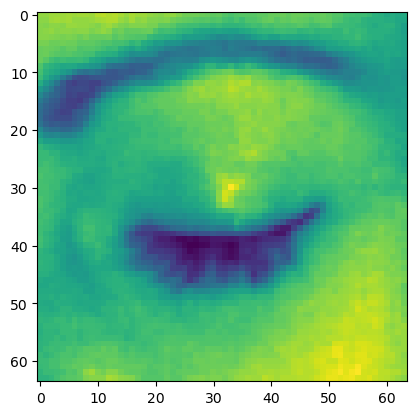

Closed
1/1 [==============================] - 0s 28ms/step


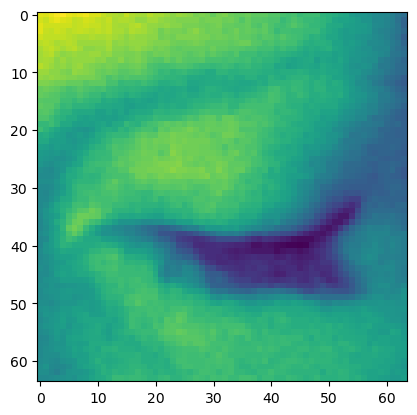

Closed
1/1 [==============================] - 0s 23ms/step


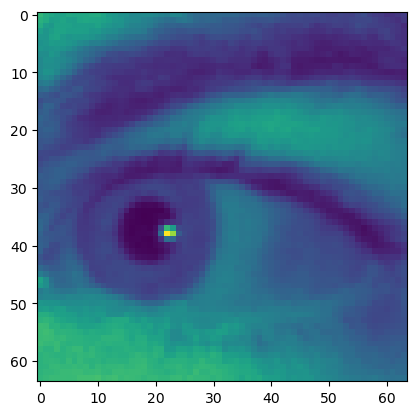

Open
1/1 [==============================] - 0s 34ms/step


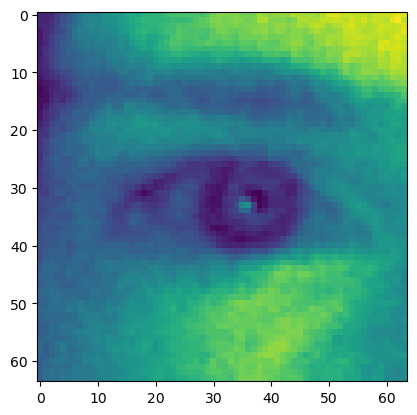

Open
1/1 [==============================] - 0s 42ms/step


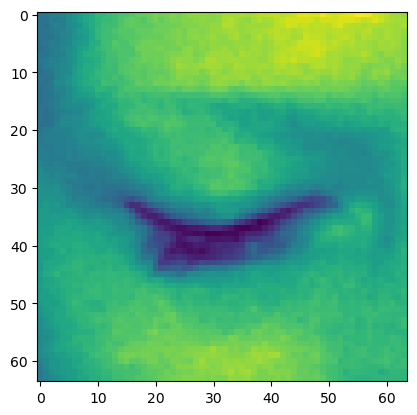

Closed


In [18]:
for i in x_test[10:15]:
    result = best_model.predict(np.expand_dims(i,0))
    plt.imshow(i)
    plt.show()
    
    if result > 0.5:
        print('Open')
    else:
        print("Closed")

42/42 [==============================] - 2s 46ms/step


Text(0.5, 25.722222222222214, 'Actual')

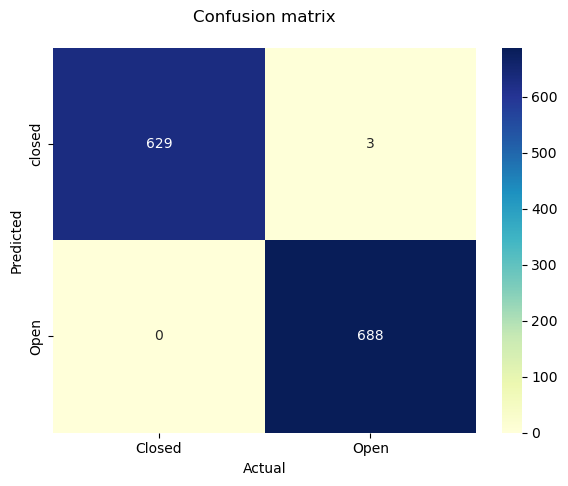

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

In [20]:
accuracy = best_model.evaluate(x_test, y_test)[1]
print("Accuracy:", accuracy)

42/42 [==============================] - 2s 49ms/step - loss: 0.0067 - accuracy: 0.9977
Accuracy: 0.9977272748947144


In [21]:
model_json = model.to_json()
with open('model_a.json',"w") as json_file:
    json_file.write(model_json)